In [1]:
model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 2 # batch size for training and evaluation

In [2]:
text_model_path = "./bert-base-finetuned-meld/checkpoint-2669/"
video_model_path = "./videomae-base-finetuned-meld/checkpoint-4069/"

In [3]:
# from huggingface_hub import hf_hub_download

# hf_dataset_identifier = "sayakpaul/ucf101-subset"
# filename = "UCF101_subset.tar.gz"
# file_path = hf_hub_download(
#     repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"
# )

# !tar xf {file_path}


In [4]:
csv_root_path = "/media/cv/Extreme Pro1/MELD.Raw/MELD.Raw"
dataset_root_path = "/media/cv/Extreme Pro1/MELD.Raw/reorganized_meld_data"

In [5]:
import pathlib
import os
dataset_root_path = pathlib.Path(dataset_root_path)
os.path.exists(dataset_root_path)


True

In [6]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.mp4")))
video_count_val = len(list(dataset_root_path.glob("dev/*/*.mp4")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.mp4")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 13707


In [7]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.mp4"))
    + list(dataset_root_path.glob("dev/*/*.mp4"))
    + list(dataset_root_path.glob("test/*/*.mp4"))
)
all_video_file_paths[:5]

[PosixPath('/media/cv/Extreme Pro1/MELD.Raw/reorganized_meld_data/train/anger/dia39_utt16.mp4'),
 PosixPath('/media/cv/Extreme Pro1/MELD.Raw/reorganized_meld_data/train/anger/dia665_utt18.mp4'),
 PosixPath('/media/cv/Extreme Pro1/MELD.Raw/reorganized_meld_data/train/anger/dia1000_utt2.mp4'),
 PosixPath('/media/cv/Extreme Pro1/MELD.Raw/reorganized_meld_data/train/anger/dia1005_utt11.mp4'),
 PosixPath('/media/cv/Extreme Pro1/MELD.Raw/reorganized_meld_data/train/anger/dia1005_utt14.mp4')]

In [8]:
class_labels = sorted({str(path).split("/")[-2] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'].


In [9]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
from transformers import (
    AutoModelForSequenceClassification, AutoTokenizer,
    TrainingArguments, Trainer
    )
import torch.nn.functional as F
import torch.nn as nn
from collections import namedtuple
import torch

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)

class TeacherBERT(nn.Module):
    def __init__(self, model_name, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.bert = AutoModelForSequenceClassification.from_pretrained(model_name).distilbert
    
    def forward(self, text):
        bert_output = self.bert(**text)[0]
        return bert_output[:, 0, :]

   
class StudentVideoMAE(nn.Module):
    def __init__(self, model_name, *args, **kwargs):
        super().__init__(*args, **kwargs)
        model = VideoMAEForVideoClassification.from_pretrained(
            model_name,
            label2id=label2id,
            id2label=id2label,
            ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
        )
        self.mae = model.videomae
        self.classifier = model.classifier
        self.criterion = nn.CrossEntropyLoss()
        self.output = namedtuple("output", ["logits", "embeds", "loss"])
        
    def forward(self, **kwargs):
            
        # if mode == 'eval':
        #     print("in eval")
        #     video = kwargs['video']
        #     labels = video['label']
        #     if len(video['video'].shape) == 4:
        #         video['video'] = video['video'].unsqueeze(0)
        #     video = video['video'].permute(0, 2, 1, 3, 4)
        # else:
        labels = kwargs['labels']
        video = kwargs["pixel_values"]
        # video = video.to(self.mae.device)
        embeds = self.mae(pixel_values=video).last_hidden_state[:, 0, :]
        logits = self.classifier(embeds)
        loss = self.get_loss(logits, labels)
        return  (logits, embeds, loss)
    
    def get_loss(self, logits, labels):
        if not isinstance(labels, torch.Tensor):
            labels = torch.tensor(labels)
        loss = self.criterion(logits, labels)
        return loss

text_model = TeacherBERT(text_model_path)        
video_model = StudentVideoMAE(video_model_path)


In [10]:
import pytorchvideo.data
import os

from pytorchvideo.data.labeled_video_paths import LabeledVideoPaths
from pytorchvideo.data.labeled_video_dataset import LabeledVideoDataset
import torch
import pandas as pd

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

In [11]:


class MELD(LabeledVideoDataset):  
    def __init__(self, filemap, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.filemap = filemap
        
    def __next__(self, *args, **kwargs):
        iter = super().__next__(*args, **kwargs)        
        iter['text'] = self.filemap[iter['video_name']]
        return iter

    
def load_video_dataset(
    filemap,
    data_path: str,
    clip_sampler,
    video_sampler,
    transform,
    video_path_prefix: str = "",
    decode_audio: bool = True,
    decoder: str = "pyav",
) -> MELD:

    labeled_video_paths = LabeledVideoPaths.from_path(data_path)
    print("Something: ", labeled_video_paths._path_prefix)
    labeled_video_paths.path_prefix = video_path_prefix
    dataset = MELD(
        filemap,
        labeled_video_paths,
        clip_sampler,
        video_sampler,
        transform,
        decode_audio=decode_audio,
        decoder=decoder,
    )
    return dataset

def filename(row, filemap, tokenizer):
    d_id = str(row['Dialogue_ID'])
    u_id = str(row['Utterance_ID'])
    filename = f'dia{d_id}_utt{u_id}.mp4'
    filemap[filename] = tokenizer(row['Utterance'], padding='max_length', truncation=True, return_tensors='pt')
    return filename    

def load_map(path, tokenizer):
    filemap = {}
    df = pd.read_csv(path)
    df['filename'] = df.apply(lambda row: filename(row, filemap, tokenizer), axis=1)
    df['Emotion'] = df['Emotion'].apply(lambda x: label2id[x])
    df = df[['Utterance', 'Emotion', 'filename']]
    df = df.rename(
        columns={
            'Utterance': 'text',
            'Emotion': 'label'
        })
    return filemap


    
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = video_model.mae.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps


# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

# Training dataset.
train_dataset = load_video_dataset(
    filemap = load_map(os.path.join(csv_root_path, "train.csv"), tokenizer),
    data_path=os.path.join(dataset_root_path, "train"),
    video_sampler=torch.utils.data.RandomSampler,
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

 
val_dataset = load_video_dataset(
    filemap = load_map(os.path.join(csv_root_path, "dev.csv"), tokenizer),
    data_path=os.path.join(dataset_root_path, "dev"),
    video_sampler=torch.utils.data.RandomSampler,
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)
 
test_dataset = load_video_dataset(
    filemap = load_map(os.path.join(csv_root_path, "test.csv"), tokenizer),
    data_path=os.path.join(dataset_root_path, "test"),
    video_sampler=torch.utils.data.RandomSampler,
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

Something:  
Something:  
Something:  


In [12]:
# We can access the `num_videos` argument to know the number of videos we have in the
# dataset.
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(9989, 1108, 2610)

In [13]:
sample_video = next(iter(train_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label', 'text'])

In [14]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for key in sample_video.keys():
        if key == "video":
            print(key, sample_video[key].shape)
        elif key == "text":
            continue
        else:
            print(key, sample_video[key])

    print(f"Video label: {id2label[sample_video['label']]}")


investigate_video(sample_video)

video torch.Size([3, 16, 224, 224])
video_name dia622_utt6.mp4
video_index 6178
clip_index 0
aug_index 0
label 4
Video label: neutral


In [15]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

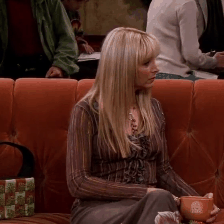

In [16]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [17]:
# Assuming `model` is your pre-trained BERT model and `test_input` is your input tensor

class ImageDistilTrainer(Trainer):
    def __init__(self, teacher_model=None, student_model=None,
                 temperature=None, lambda_param=None, *args, **kwargs):
        super().__init__(model=student_model, *args, **kwargs)
        self.teacher_model = teacher_model
        self.student_model = student_model
        self.teacher_model.to(self.student_model.mae.device)
        self.loss_function = torch.nn.KLDivLoss(reduction="batchmean")
        self.loss_function_logits = torch.nn.CrossEntropyLoss()
        
        self.lambda_param = lambda_param
        self.temperature = temperature
        self.labels = None
     

    def compute_loss(self, student, inputs, return_outputs=False):
        self.labels = inputs['labels']         
        with torch.no_grad():
            teacher_embeds = self.teacher_model(inputs['text'])
        student_logits, student_embeds, studnet_loss = self.student_model(**inputs)
        
        
        soft_student = F.softmax(student_embeds/ self.temperature, dim=-1) 
        soft_teacher = F.softmax(teacher_embeds/self.temperature, dim=-1)
        
        distillation_loss = self.loss_function(soft_student, soft_teacher) * (self.temperature ** 2)

        # Compute the true label loss
        student_target_loss = studnet_loss

        # Calculate final loss
        loss = (1. - self.lambda_param) * student_target_loss + self.lambda_param * distillation_loss
        
        return (loss, student_logits) if return_outputs else loss

In [18]:
def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    # for example in examples:
    #     print("video tensor:", 
    #           example["video"]["video"].permute(1, 0, 2, 3).shape, 
    #           example["video"]["video"].device)
    #     print("TEXT: ")
    #     print("input_ids: ", example['text']['input_ids'].shape, example['text']['input_ids'].device)
    #     print("input_ids: ", example['text']['attention_mask'].shape, example['text']['attention_mask'].device)
    #     break
    
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    
    text = {
    'input_ids': torch.stack([example['text']['input_ids'][0] for example in examples]),
    'attention_mask': torch.stack([example['text']['attention_mask'][0] for example in examples])
    }
    
    
    labels = torch.tensor([example["label"] for example in examples])
    
    return {"pixel_values": pixel_values, "labels": labels, 'label_ids': labels, "text" : text}

In [19]:
from sklearn.metrics import accuracy_score, f1_score

model_name = "distilled-vmae"
num_epochs = 4

args = TrainingArguments(
    model_name,
    label_names='labels',
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1_score",
    max_steps= (train_dataset.num_videos // batch_size) * num_epochs,
    save_total_limit =3,
)

trainer = ImageDistilTrainer(
    student_model=video_model,
    teacher_model=text_model,
    temperature=5,
    lambda_param=0.5,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    # tokenizer=teacher_processor,
    compute_metrics= lambda pred: {
        "accuracy": accuracy_score(pred.label_ids, pred.predictions[0].argmax(-1)),
        "f1_score": f1_score(pred.label_ids, pred.predictions[0].argmax(-1), average='weighted')
    },
)

/home/cv/anaconda3/envs/tte/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [20]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Score
0,-82.239300,No log,0.402649,0.244902


/home/cv/anaconda3/envs/tte/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


KeyboardInterrupt: 

In [22]:
preds = trainer.predict(val_dataset)

In [ ]:
preds.label_oids

PredictionOutput(predictions=(array([[ 1.14095025e-01, -1.70458484e+00, -2.79825479e-01,
        -9.76461887e-01,  1.77775753e+00, -3.66343290e-01,
         6.28172398e-01],
       [ 7.43781552e-02, -5.11486888e-01, -1.58502173e+00,
        -3.29411536e-01,  6.61224008e-01,  1.21893749e-01,
         4.03205365e-01],
       [-9.72509682e-02, -1.15519404e+00, -1.69063544e+00,
        -5.72379641e-02,  1.98869288e+00, -8.27251077e-01,
         2.28556335e-01],
       [ 2.49056980e-01, -1.43261659e+00, -2.06018782e+00,
         4.25376654e-01,  1.71668077e+00, -6.20184481e-01,
         1.20652401e+00],
       [-1.70912847e-01, -8.97166610e-01, -1.55427647e+00,
         7.09077537e-01,  1.79599512e+00, -5.41175544e-01,
        -1.72147587e-01],
       [-1.28075755e+00, -8.64014626e-01, -1.57476497e+00,
         7.00237989e-01,  2.09751940e+00, -3.77338141e-01,
         8.78296793e-01],
       [-9.55639720e-01, -1.97895145e+00, -1.51248980e+00,
         1.46126318e+00,  2.02435493e+00, -8.59

In [ ]:
preds.predictions[0].argmax(dim=-1)

TypeError: argmax() got an unexpected keyword argument 'dim'

In [ ]:
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

## Inference

In [ ]:
trained_model = VideoMAEForVideoClassification.from_pretrained(new_model_name)

In [ ]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)

In [ ]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.
    
    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [ ]:
logits = run_inference(trained_model, sample_test_video["video"])
display_gif(sample_test_video["video"])

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])